In [118]:
# trying to get a handle on uncertainty values
import os
import sys
import glob
import pickle
import copy
import pandas as pd
import numpy as np
import rmgpy.rmg.input  # note this method is currently broken for multiple reactors in an input file
import rmgpy.rmg.main
import rmgpy.chemkin
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties

import rmgpy.tools.canteramodel
import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def plot_thermos(thermos, labels=None, Tmin=300, Tmax=2000):
    if type(thermos) != list:
        thermos = [thermos]
    if labels is None:
        labels = ['' for t in thermos]
    linestyles = ['solid', 'solid', 'dashed', 'dashed']
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(Tmin, Tmax, 1001)
#     T = np.linspace(300, 3000, 1001)
    for n, thermo in enumerate(thermos):
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        for i in range(0, len(T)):
            H[i] = thermo.get_enthalpy(T[i]) / 1000.0
            S[i] = thermo.get_entropy(T[i]) / 1000.0
            Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        ax[0].plot(T, H, linestyle=linestyles[n % len(linestyles)])
        ax[1].plot(T, S, linestyle=linestyles[n % len(linestyles)])
        ax[2].plot(T, Cp, linestyle=linestyles[n % len(linestyles)])
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    ax[2].yaxis.get_major_formatter().set_useOffset(False)
    plt.subplots_adjust(wspace=0.25)
    plt.show()


In [3]:
thermo_lib_paths = glob.glob(os.path.join(rmgpy.settings['database.directory'], 'thermo', 'libraries', '*'))

In [4]:
# thermo_libs = [os.path.basename(x).replace('.py', '') for x in thermo_lib_paths]

thermo_libs = []
for i in range(len(thermo_lib_paths)):
    if 'surface' in thermo_lib_paths[i].lower():
        continue
    thermo_libs.append(os.path.basename(thermo_lib_paths[i]).replace('.py', ''))

In [5]:
def get_i_thing(thing, thing_list):
    for i in range(len(thing_list)):
        if thing.is_isomorphic(thing_list[i]):
            return i
    return None

In [6]:
# load all thermo libraries
database = rmgpy.data.rmg.RMGDatabase()
database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = thermo_libs,
    transport_libraries = [],
    reaction_libraries = [],
    seed_mechanisms = [],
    kinetics_families = [],
    kinetics_depositories = ['training'],
    depository = False,
)

In [7]:
all_libraries = list(database.thermo.libraries.keys())

In [8]:
# make a list of every species

In [9]:
# Pick a species, get the spread on uncertainty for it
my_species = rmgpy.species.Species(smiles='C')
my_species = rmgpy.species.Species(smiles='CC')
# my_species = rmgpy.species.Species(smiles='CCO')
# my_species = rmgpy.species.Species(smiles='[O][O]')

In [10]:
def sp_in_library(sp, database, library_name):
    item_list = [database.thermo.libraries[library_name].entries[key].item \
                 for key in database.thermo.libraries[library_name].entries.keys()]
    i_sp = get_i_thing(sp.molecule[0], item_list)
    return i_sp is not None
    

In [11]:
database.thermo.get_thermo_data_from_groups(my_species)

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([51.7979,65.6051,78.6592,90.2907,108.951,123.595,147.109],'J/(mol*K)'), H298=(-85.3536,'kJ/mol'), S298=(254.471,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsHHH) + group(Cs-CsHHH)""")

In [12]:
# get the library value for every single 
results = {}

# TODO add GAV
gav_thermo = database.thermo.get_thermo_data_from_groups(my_species)
if not isinstance(gav_thermo, rmgpy.thermo.NASA):
    gav_thermo = gav_thermo.to_nasa(Tmin=200, Tmax=3000, Tint=1000)
results['GAV'] = gav_thermo

for lib in list(database.thermo.libraries.keys()):
    # is species in there?
    if not sp_in_library(my_species, database, lib):
        continue

    thermo, library, entry = database.thermo.get_thermo_data_from_library(my_species, database.thermo.libraries[lib])
    if not isinstance(thermo, rmgpy.thermo.NASA):
        thermo = thermo.to_nasa(Tmin=200, Tmax=3000, Tint=1000)
    results[lib] = thermo

thermos = [results[key] for key in results.keys()]
thermo_labels = list(results.keys())

In [17]:
thermo_labels

['GAV',
 'NOx2018',
 'LithiumPrimaryThermo2',
 'GRI-Mech3.0-N',
 '2-BTP',
 'JetSurF2.0',
 'DFT_QCI_thermo',
 'JetSurF1.0',
 'thermo_DFT_CCSDTF12_BAC',
 'Chernov',
 'USC-Mech-ii',
 'Klippenstein_Glarborg2016',
 'FFCM1(-)',
 'CH',
 'CurranPentane',
 'GRI-Mech3.0',
 'Narayanaswamy',
 'Fluorine']

# Plot H, S, Cp zoomed out

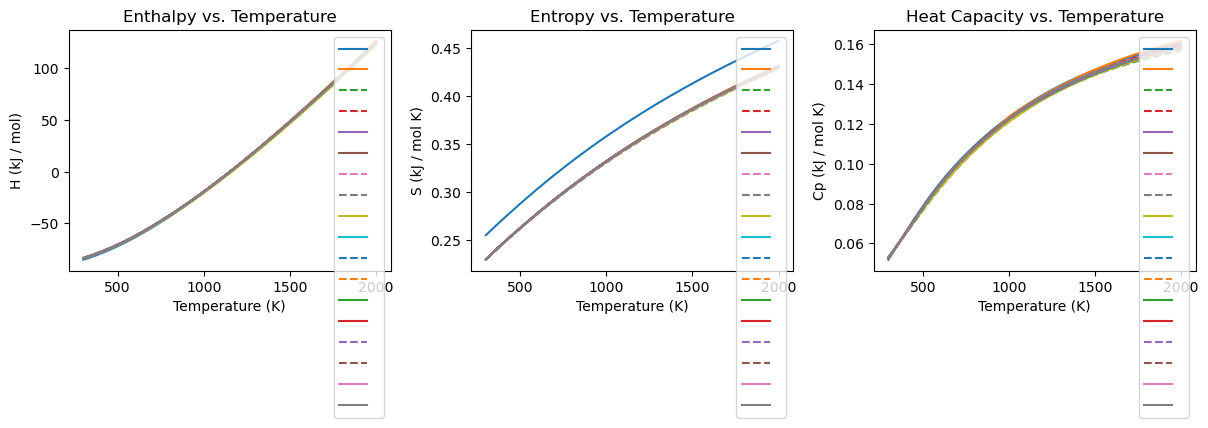

In [16]:
plot_thermos(thermos)

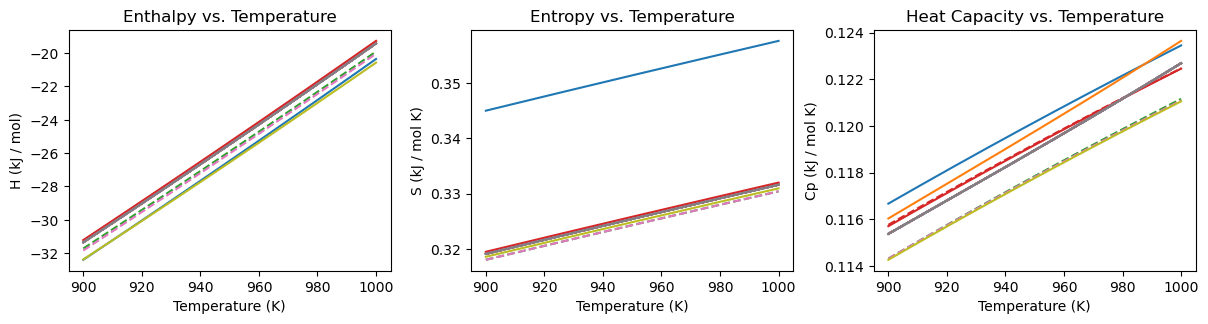

In [14]:
plot_thermos(thermos, Tmin=900, Tmax=1000)

# Plot Gibbs energy zoomed out

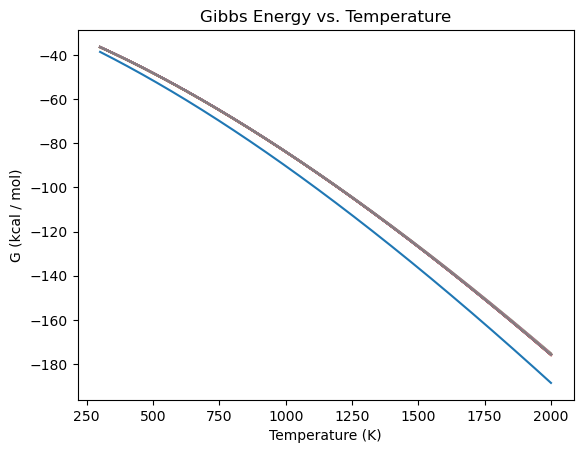

In [18]:
T = np.linspace(300, 2000, 1001)
for n, thermo in enumerate(thermos):
    G = np.zeros(len(T))
    for i in range(0, len(T)):
        G[i] = thermo.get_free_energy(T[i]) / 4184
    plt.plot(T, G)
   
ax = plt.gca()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('G (kcal / mol)')
ax.set_title('Gibbs Energy vs. Temperature')

ax.yaxis.get_major_formatter().set_useOffset(False)
plt.subplots_adjust(wspace=0.25)
plt.show()


In [20]:
thermos[0]

NASA(polynomials=[NASAPolynomial(coeffs=[2.56615,0.00388002,4.3642e-05,-6.03944e-08,2.54699e-11,-11480.5,13.3747], Tmin=(200,'K'), Tmax=(749.937,'K')), NASAPolynomial(coeffs=[0.220828,0.0241452,-1.24046e-05,3.21928e-09,-3.3357e-13,-11346.9,22.5605], Tmin=(749.937,'K'), Tmax=(3000,'K'))], Tmin=(200,'K'), Tmax=(3000,'K'), E0=(-96.3961,'kJ/mol'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsHHH) + group(Cs-CsHHH)""")

In [21]:
thermo_labels[0]

'GAV'

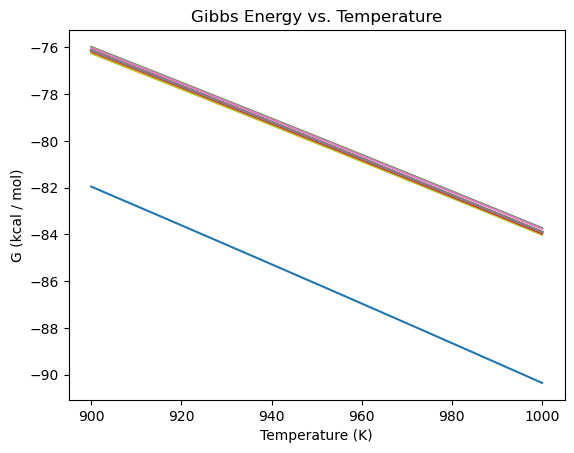

In [22]:
T = np.linspace(900, 1000, 1001)
for n, thermo in enumerate(thermos):
    G = np.zeros(len(T))
    for i in range(0, len(T)):
        G[i] = thermo.get_free_energy(T[i]) / 4184
    plt.plot(T, G)
   
ax = plt.gca()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('G (kcal / mol)')
ax.set_title('Gibbs Energy vs. Temperature')

ax.yaxis.get_major_formatter().set_useOffset(False)
plt.subplots_adjust(wspace=0.25)
plt.show()


# plot the spread on Gibbs Energies at different temperatures

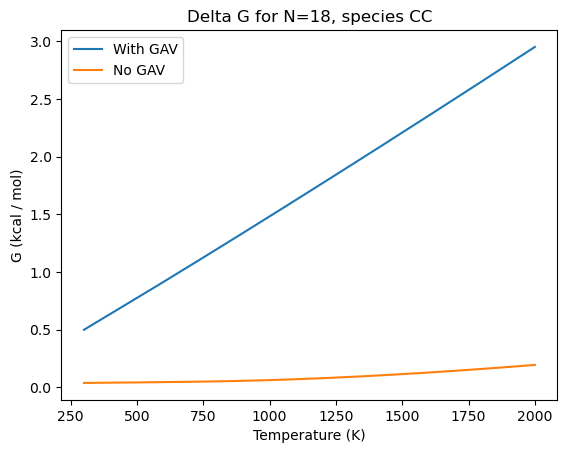

In [30]:
T = np.linspace(300, 2000, 1001)
Gs = np.zeros((len(thermos), len(T)))

for n, thermo in enumerate(thermos):
    for i in range(0, len(T)):
        Gs[n, i] = thermo.get_free_energy(T[i]) / 4184
    # plt.plot(T, Gs[n, :])
# mean = np.average(Gs, axis=0)

std_devs = np.std(Gs, axis=0)
plt.plot(T, std_devs, label='With GAV')

std_devs_noGAV = np.std(Gs[1:, :], axis=0)
plt.plot(T, std_devs_noGAV, label='No GAV')

ax = plt.gca()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('G (kcal / mol)')
ax.set_title(f'Delta G for N={len(thermos)}, species {str(my_species.smiles)}')

ax.yaxis.get_major_formatter().set_useOffset(False)
plt.subplots_adjust(wspace=0.25)
plt.legend()
plt.show()


In [31]:
thermo_labels

['GAV',
 'NOx2018',
 'LithiumPrimaryThermo2',
 'GRI-Mech3.0-N',
 '2-BTP',
 'JetSurF2.0',
 'DFT_QCI_thermo',
 'JetSurF1.0',
 'thermo_DFT_CCSDTF12_BAC',
 'Chernov',
 'USC-Mech-ii',
 'Klippenstein_Glarborg2016',
 'FFCM1(-)',
 'CH',
 'CurranPentane',
 'GRI-Mech3.0',
 'Narayanaswamy',
 'Fluorine']

In [32]:
# Compile list of all species in all these libraries

all_species = []
for i in range(len(thermo_libs)):
    lib = thermo_libs[i]
    thermo_lib_item_list = [database.thermo.libraries[lib].entries[key].item \
                            for key in database.thermo.libraries[lib].entries.keys()]
    new_sp_list = []
    for j in range(len(thermo_lib_item_list)):
        ref_sp = rmgpy.species.Species(molecule=[thermo_lib_item_list[j]])
        if ref_sp.contains_surface_site():
            continue
        
        existing_index = get_i_thing(ref_sp, all_species)
        if existing_index is None:
            new_sp_list.append(ref_sp)
    all_species += new_sp_list
    print(f'Using {len(new_sp_list)} species out of {len(thermo_lib_item_list)} from {lib}')


# thermo, library, entry = database.thermo.get_thermo_data_from_library(my_species, database.thermo.libraries[lib])

Using 148 species out of 148 from NOx2018
Using 26 species out of 26 from halogens
Using 148 species out of 157 from LithiumPrimaryThermo2
Using 0 species out of 12 from Cr110_gemnet
Using 1775 species out of 1775 from CHOFCl_G4
Using 3 species out of 51 from GRI-Mech3.0-N
Using 0 species out of 10 from Fe111_gemnet
Using 37 species out of 39 from SulfurGlarborgH2S
Using 189 species out of 199 from SulfurLibrary
Using 27 species out of 48 from primaryThermoLibrary
Using 38 species out of 38 from C10H11
Using 300 species out of 331 from SABIC_aromatics_1dHR
Using 202 species out of 210 from Spiekermann_refining_elementary_reactions
Using 48 species out of 51 from Chlorinated_Hydrocarbons
Using 86 species out of 94 from CHON
Using 2 species out of 37 from SulfurGlarborgMarshall
Using 0 species out of 16 from LithiumAdditionalThermo
Using 113 species out of 172 from 2-BTP
Using 334 species out of 354 from CHO
Using 9 species out of 25 from harris_butane_min10_separate_0008
Using 1922 spec

In [33]:
len(all_species)

22120

In [88]:
all_species[0]

In [85]:
rmgpy.chemkin.save_species_dictionary('species_dictionary.txt', all_species)

In [105]:
new_dict = rmgpy.chemkin.load_species_dictionary('species_dictionary.txt')

KeyboardInterrupt: 

In [121]:
gav_thermo = database.thermo.get_thermo_data_from_groups(all_species[0])

In [122]:
database.thermo.

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.5973,47.865,51.6306,55.7309,59.8312,63.6805,70.5422],'J/(mol*K)'), H298=(-136.398,'kJ/mol'), S298=(232.881,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(78.9875,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsH) + group(O2s-OsH)""")

# Make a histogram of how many instances there are in the database

In [34]:
instances = np.zeros(len(all_species))

# make a huge G array for each species, last row is always GAV
Ts = np.array([300, 500, 800, 1000, 1200, 1500])

# make a huge matrix of all Gs
#species x (libraries) x Ts
Gs_lib = np.zeros((len(all_species), len(all_libraries), len(Ts))) + np.nan
Gs_GAV = np.zeros((len(all_species), len(Ts))) + np.nan
for i_sp in range(len(all_species)):
    if i_sp % 1000 == 0:
        print(i_sp)
    for i_lib, lib in enumerate(all_libraries):
        
        if not sp_in_library(all_species[i_sp], database, lib):
            continue
        
        thermo_query = database.thermo.get_thermo_data_from_library(all_species[i_sp], database.thermo.libraries[lib])
        if thermo_query is None:
            print(f'problem on {i_sp}, {all_species[i_sp]}, {lib}')
            continue
        instances[i_sp] += 1
        thermo, library, entry = thermo_query
        if not isinstance(thermo, rmgpy.thermo.NASA):
            thermo = thermo.to_nasa(Tmin=200, Tmax=3000, Tint=1000)
        
        for j in range(len(Ts)):
            if Ts[j] > thermo.Tmax.value_si:
                break
            Gs_lib[i_sp, i_lib, j] = thermo.get_free_energy(Ts[j])
        
    # get GAV values
    try:
        gav_thermo = database.thermo.get_thermo_data_from_groups(all_species[i_sp])
        if not isinstance(gav_thermo, rmgpy.thermo.NASA):
            gav_thermo = gav_thermo.to_nasa(Tmin=200, Tmax=3000, Tint=1000)
        for j in range(len(Ts)):
            Gs_GAV[i_sp, j] = gav_thermo.get_free_energy(Ts[j])
    except (rmgpy.exceptions.DatabaseError, KeyError):
        continue
        




0
problem on 3, [H], vinylCPD_H
problem on 14, [CH3], vinylCPD_H
problem on 20, C=C, vinylCPD_H
problem on 25, [CH]=C, vinylCPD_H
1000
2000


ERROR:root:Couldn't find in radical thermo database:
ERROR:root:<Molecule "[C]">
ERROR:root:multiplicity 5
1 C u4 p0 c0



3000
4000
5000
problem on 5407, C#CCC([CH2])=C, C3
problem on 5408, C=C1C[C]=CC1, C3


ERROR:root:Couldn't find in main thermo database:
ERROR:root:<Molecule "e">
ERROR:root:1 e u0 p0 c-1



6000
7000
8000
9000
10000
11000
12000


/home/moon/anaconda3/envs/rmg_2026/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2322: LinAlgWarning: Ill-conditioned matrix (rcond=5.24102e-18): result may not be accurate.
  fu = func(x, *args)


13000
14000
15000
16000
17000
18000
19000
problem on 19435, N#CCCC=CC#N, CHN
problem on 19436, c1ccc[nH]1, CHN
problem on 19437, [CH]1[CH][CH][CH][N][CH]1, CHN
problem on 19438, C[C]1[CH][CH][CH][CH][N]1, CHN
problem on 19439, C[C]1[CH][CH][CH][N][CH]1, CHN
problem on 19440, C[C]1[CH][CH][N][CH][CH]1, CHN
problem on 19441, N#C[C]1[CH][CH][CH][CH][CH]1, CHN
problem on 19442, NC[C]1[CH][CH][CH][CH][CH]1, CHN
20000


/home/moon/anaconda3/envs/rmg_2026/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2322: LinAlgWarning: Ill-conditioned matrix (rcond=1.93135e-17): result may not be accurate.
  fu = func(x, *args)


21000
22000


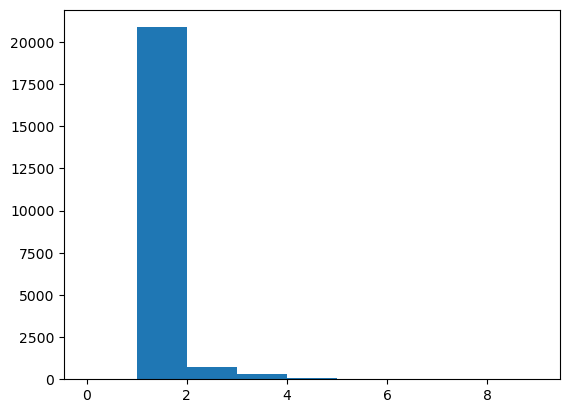

In [36]:
y= plt.hist(instances, bins=np.arange(10))

In [42]:
np.sum(y[0][2:])

1192.0

In [43]:
np.save('all_Gs_lib.npy', Gs_lib)

In [44]:
np.save('all_Gs_GAV.npy', Gs_GAV)

# Get std of G lib

In [45]:
# Analyze the matrix
G_lib_std = np.nanstd(Gs_lib[:, :-1, :], axis=1) / 4184
G_lib_mean = np.nanmean(Gs_lib[:, :-1, :], axis=1) / 4184

/home/moon/anaconda3/envs/rmg_2026/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2141/4081854360.py:3: RuntimeWarning: Mean of empty slice
  G_lib_mean = np.nanmean(Gs_lib[:, :-1, :], axis=1) / 4184


In [53]:
instances > 1.0

array([ True,  True,  True, ..., False, False, False])

Mean of std dev 1.4414546371744297
Median of std dev 0.7003215940424717


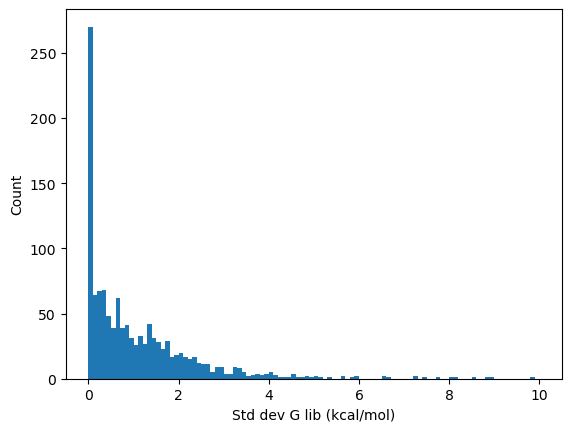

In [61]:
# plt.hist(G_lib_std[:, 3], bins=np.linspace(0, 10, 101))
plt.hist(G_lib_std[instances > 1.0, 3], bins=np.linspace(0, 10, 101))

plt.xlabel('Std dev G lib (kcal/mol)')
plt.ylabel('Count')

print('Mean of std dev', np.mean(G_lib_std[instances > 1.0, 3]))
print('Median of std dev', np.median(G_lib_std[instances > 1.0, 3]))

# Get GAV Errors

Mean of GAV error 3.5423197066215333
Median of GAV error 2.0176485156404453
Sigma= 4.439639367200063


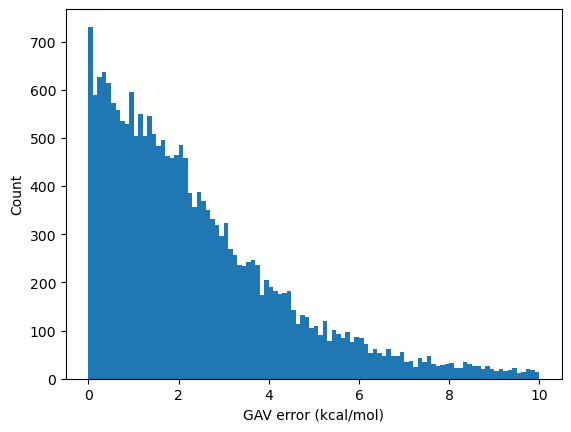

In [76]:
GAV_errors = np.abs((Gs_GAV / 4184) - G_lib_mean)


# plt.hist(GAV_errors[instances > 1.0, 3], bins=np.linspace(0, 10, 101))

plt.xlabel('GAV error (kcal/mol)')
plt.ylabel('Count')

filter_single_mentions = False

if not filter_single_mentions:
    plt.hist(GAV_errors[:, 3], bins=np.linspace(0, 10, 101))
    MAE = np.nanmean(GAV_errors[:, 3])
    print('Mean of GAV error', MAE)
    print('Median of GAV error', np.nanmedian(GAV_errors[:, 3]))
else:
    plt.hist(GAV_errors[instances > 1.0, 3], bins=np.linspace(0, 10, 101))
    MAE = np.nanmean(GAV_errors[instances > 1.0, 3])
    print('Mean of GAV error', MAE)
    print('Median of GAV error', np.nanmedian(GAV_errors[instances > 1.0, 3]))

sigma = MAE / np.sqrt(2.0 / np.pi)
print('Sigma=', sigma)
# print('Median of std dev', np.mean(GAV_errors[instances > 1.0, 3]))

Mean of GAV error 7.545269728505843
Median of GAV error 3.1430797161759045
Sigma= 9.45659322059506


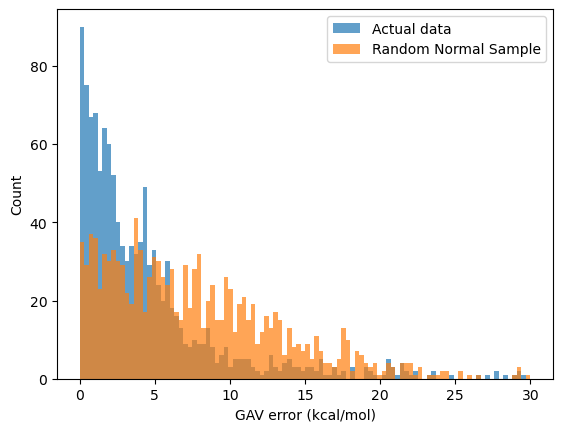

In [96]:
# Does my conversion from MAE to sigma make sense?
np.random.seed(400)
GAV_errors = np.abs((Gs_GAV / 4184) - G_lib_mean)

plt.xlabel('GAV error (kcal/mol)')
plt.ylabel('Count')

filter_single_mentions = True

MAX_ERROR = 30.0
if not filter_single_mentions:
    plt.hist(GAV_errors[:, 3], bins=np.linspace(0, MAX_ERROR, 101), alpha=0.7, label='Actual data')
    MAE = np.nanmean(GAV_errors[:, 3])
    print('Mean of GAV error', MAE)
    print('Median of GAV error', np.nanmedian(GAV_errors[:, 3]))

    N = GAV_errors.shape[0]
else:
    plt.hist(GAV_errors[instances > 1.0, 3], bins=np.linspace(0, MAX_ERROR, 101), alpha=0.7, label='Actual data')
    MAE = np.nanmean(GAV_errors[instances > 1.0, 3])
    print('Mean of GAV error', MAE)
    print('Median of GAV error', np.nanmedian(GAV_errors[instances > 1.0, 3]))

    N = GAV_errors[instances > 1.0, 3].shape[0]
sigma = MAE / np.sqrt(2.0 / np.pi)
print('Sigma=', sigma)


samples = np.random.normal(scale=sigma, size=N)
sample_error = np.abs(samples)
plt.hist(sample_error, bins=np.linspace(0, MAX_ERROR, 101), alpha=0.7, label='Random Normal Sample')

plt.legend()
# print('Median of std dev', np.mean(GAV_errors[instances > 1.0, 3]))

In [100]:
# What fraction of GAV estimated are outside 95% confidence interval?   6%. That's why it's the 95% confidence interval
np.sum(np.abs(GAV_errors[:, 3]) > 2.0 * 4.43963) / GAV_errors.shape[0]




0.061301989150090413

In [112]:
# What is the average # rotors for sp outside 95% confidence interval

all_species[i].molecule[0].count_internal_rotors()

2

# Make a dataframe for GAV and lib error analysis

In [120]:
col_names = ['error kcal/mol', 'lib instances', 'n rotors', 'n heavy', 'MW', 'is_aromatic', 'has_halogen', 'has_lone_pairs', 'is_cyclic', 'is_radical']
df = pd.DataFrame(columns=col_names)
for i in range(len(all_species)):
    if i % 1000 == 0:
        print(i)
    n_rotors = all_species
    
    df.loc[i] = [
        GAV_errors[i, 3],
        instances[i], 
        all_species[i].molecule[0].count_internal_rotors(),
        all_species[i].molecule[0].get_num_atoms() - np.sum([x.symbol == 'H' for x in all_species[i].molecule[0].atoms]),
        all_species[i].molecule[0].get_molecular_weight(),
        all_species[i].molecule[0].is_aromatic(),
        all_species[i].molecule[0].has_halogen(),
        all_species[i].molecule[0].has_lone_pairs(),
        all_species[i].molecule[0].is_cyclic(),
        all_species[i].molecule[0].is_radical(),
    ]

df.to_csv('GAV_conditional_error.csv')


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


# Fit a decision tree

In [147]:
y = df['error kcal/mol'].values
X = np.array(df)[:, 1:]

# drop nans
X = X[~np.isnan(y), :]
y = y[~np.isnan(y)]

# split into test and train
np.random.seed(400)
indices = np.random.permutation(len(y))

train_frac = 0.7
N_train = int(len(y) * train_frac)

y_train = y[indices[:N_train]]
y_test = y[indices[N_train:]]

X_train = X[indices[:N_train], :]
X_test = X[indices[N_train:], :]



In [160]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=10)
regr_4 = DecisionTreeRegressor(max_depth=20)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)
regr_3.fit(X_train, y_train)
regr_4.fit(X_train, y_train)




DecisionTreeRegressor(max_depth=20)

In [161]:
y_predict1 = regr_1.predict(X_test)
y_predict2 = regr_2.predict(X_test)
y_predict3 = regr_3.predict(X_test)
y_predict4 = regr_4.predict(X_test)

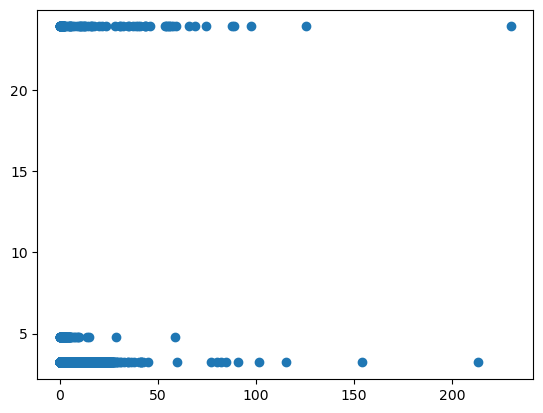

In [151]:
plt.scatter(y_test, y_predict1)

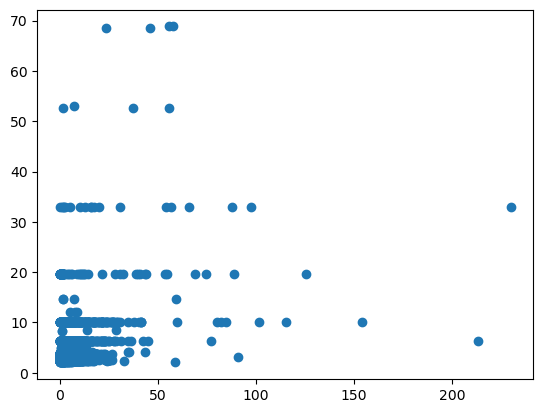

In [152]:
plt.scatter(y_test, y_predict2)

(-0.1, 30.0)

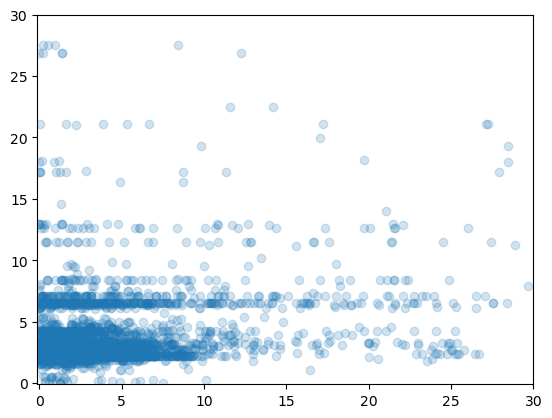

In [159]:
plt.scatter(y_test, y_predict3, alpha=0.2)
plt.xlim([-0.1, 30.0])
plt.ylim([-0.1, 30.0])

(-0.1, 10.0)

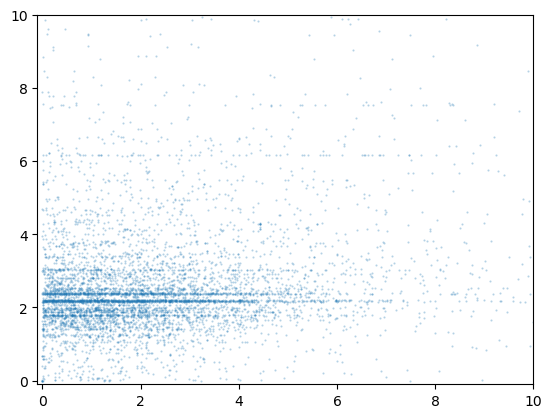

In [168]:
plt.scatter(y_test, y_predict4, s=0.3, alpha=0.3)
plt.xlim([-0.1, 10.0])
plt.ylim([-0.1, 10.0])

In [169]:
from sklearn.neural_network import MLPRegressor

In [170]:
regr = MLPRegressor(random_state=1, max_iter=2000, tol=0.1)
regr.fit(X_train, y_train)

MLPRegressor(max_iter=2000, random_state=1, tol=0.1)

In [171]:
regr.score(X_test, y_test)

0.1668169730499207

In [173]:
regr_1.score(X_test, y_test)

0.09541082037715887

In [174]:
regr_2.score(X_test, y_test)

0.16111152150504837

In [175]:
regr_3.score(X_test, y_test)

0.10129291236808591

In [176]:
regr_4.score(X_test, y_test)

-0.2497266368827995

In [177]:
# formally compute the number of groups in this set

In [178]:
all_species[0]

In [ ]:
database

(-0.1, 10.0)

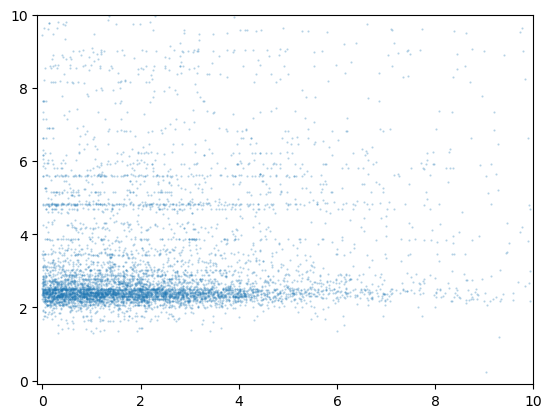

In [172]:
plt.scatter(y_test, regr.predict(X_test), s=0.3, alpha=0.3)
plt.xlim([-0.1, 10.0])
plt.ylim([-0.1, 10.0])

In [124]:
P(

0.0

In [116]:
all_species[0].molecule[0].has_halogen

In [113]:
all_species[i].molecule[0].get_num_atoms() - np.sum([x.symbol == 'H' for x in all_species[i].molecule[0].atoms])

6

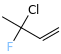

In [114]:
all_species[i]

# See how errors correlate with # rotors and heavy atoms

In [97]:
internal_rotors = np.zeros(len(all_species)) + np.nan
for i_sp in range(len(internal_rotors)):
    internal_rotors[i_sp] = all_species[i_sp].molecule[0].count_internal_rotors()

In [101]:
np.mean(internal_rotors)

2.133137432188065

(-0.1, 10.0)

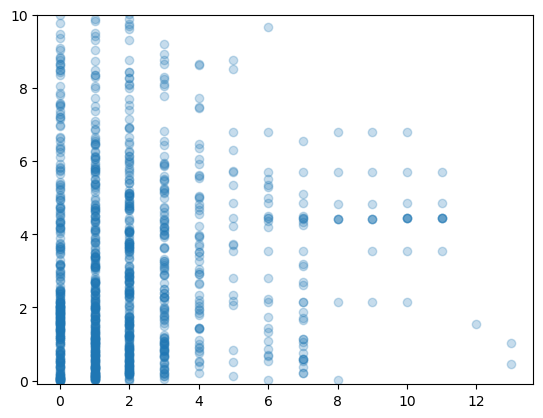

In [105]:
# plt.scatter(internal_rotors, np.abs(GAV_errors[:, 3]), alpha=0.25)
plt.scatter(internal_rotors[instances > 1.0], np.abs(GAV_errors[instances > 1.0, 3]), alpha=0.25)

plt.ylim([-0.1, 10.0])

In [194]:
weights = np.zeros(len(all_species)) + np.nan
for i_sp in range(len(weights)):
    weights[i_sp] = all_species[i_sp].molecule[0].get_molecular_weight()

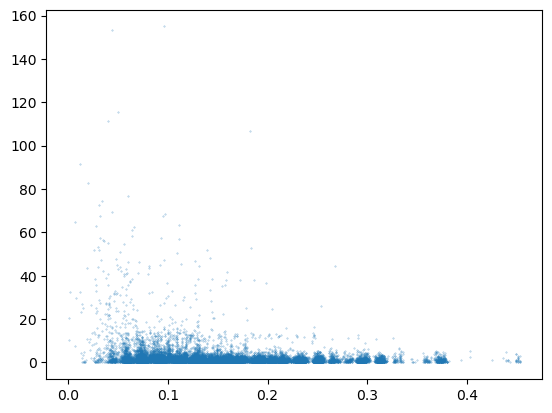

In [199]:
plt.scatter(weights, np.abs(GAV_errors[:, 3]), alpha=0.55, s=0.1)

In [204]:
n_heavy = np.zeros(len(all_species)) + np.nan
for i_sp in range(len(n_heavy)):
    n_heavy[i_sp] = all_species[i_sp].molecule[0].get_num_atoms() - np.sum([x.symbol == 'H' for x in all_species[i_sp].molecule[0].atoms])

In [203]:
# get GAV values

n_groups = np.zeros(len(all_species)) + np.nan
for i_sp in range(len(all_species)):
    if i_sp % 1000 == 0:
        print(i_sp)
    try:
        gav_thermo = database.thermo.get_thermo_data_from_groups(all_species[i_sp])
        all_species[i_sp].thermo = gav_thermo
        entry = database.thermo.extract_source_from_comments(all_species[i_sp])


        group_count = 0
        for group_type_key in entry['GAV'].keys():  # group_type_key will be group, radical etc
            list_of_group_entries = entry['GAV'][group_type_key]
            for group_entry in list_of_group_entries:
                group_count += group_entry[1]
        n_groups[i_sp] = group_count
    except (rmgpy.exceptions.DatabaseError, KeyError, ValueError):
        continue

0
1000
2000


ERROR:root:Couldn't find in radical thermo database:
ERROR:root:<Molecule "[C]">
ERROR:root:multiplicity 5
1 C u4 p0 c0



3000
4000
5000


ERROR:root:Couldn't find in main thermo database:
ERROR:root:<Molecule "e">
ERROR:root:1 e u0 p0 c-1



6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [207]:
np.save('n_groups.py', n_groups)

Median= 5.0
Mean= 5.559909502262443


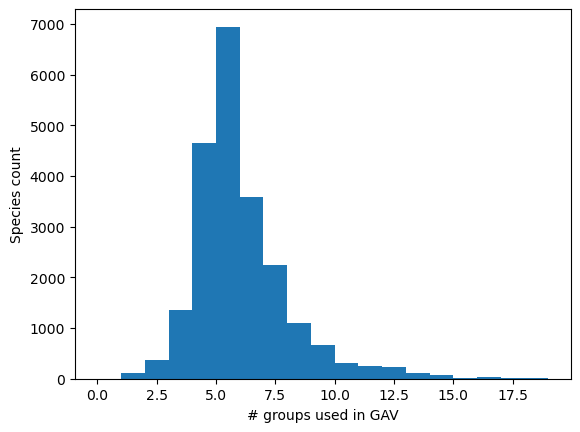

In [211]:
plt.hist(n_groups, bins=np.arange(0, 20))
plt.xlabel('# groups used in GAV')
plt.ylabel('Species count')

print('Median=', np.nanmedian(n_groups))
print('Mean=', np.nanmean(n_groups))

In [270]:
Delta_G_GAVs = np.linspace(0.1, 5.0, 1001)
Delta_G_groups = np.linspace(0.01, 2.0, 5001)

DELTA_G_GAVS, DELTA_G_GROUPS = np.meshgrid(Delta_G_GAVs, Delta_G_groups)
n = 5.0  # median
# n = 5.5599  # mean
DELTA_GS = np.sqrt(np.float_power(DELTA_G_GAVS, 2.0) + np.float_power(n, 2.0) * np.float_power(DELTA_G_GROUPS, 2.0))


In [271]:
a = np.argmin(np.abs(DELTA_GS - 4.44))

In [272]:
DELTA_G_GAVS.ravel()[a]

2.3687000000000005

In [273]:
DELTA_G_GROUPS.ravel()[a]

0.7510760000000001

# Predict uncertainty using new calculation method

In [309]:
def get_uncertainty(group_count, dG_GAV=2.3687000, dG_group=0.75):
    return np.sqrt(dG_GAV ** 2.0 + np.float_power(group_count, 2.0) * dG_group ** 2.0)

def get_uncertainty_og(group_count, dG_GAV=1.5, dG_group=0.1):
    return dG_GAV + group_count * dG_group
    

In [264]:
get_uncertainty(5, dG_GAV=2.3687000000000005, dG_group=0.75)

4.435452591337214

In [260]:
get_uncertainty(5, dG_GAV=3.383, dG_group=0.57)

4.423481547378716

In [261]:
get_uncertainty(5, dG_GAV=1.5, dG_group=0.1)

1.5811388300841898

In [263]:
get_uncertainty(5, dG_GAV=1.5, dG_group=0.5)

2.9154759474226504

std= 4.847542695340263
Mean of GAV error 3.5423197066215333
Median of GAV error 2.0176485156404453
Sigma= 4.439639367200063


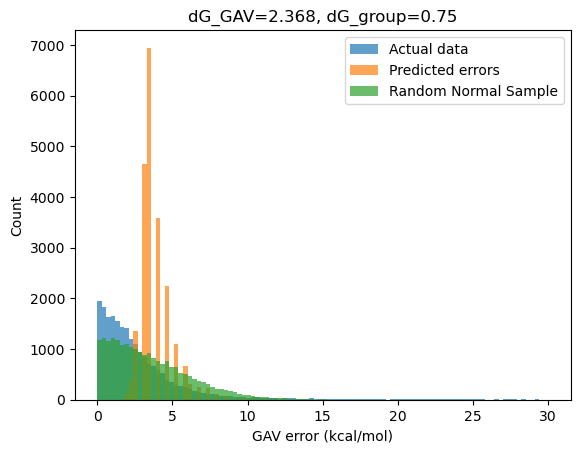

In [316]:
# Does my conversion from MAE to sigma make sense?
np.random.seed(400)

dG_GAV=2.368
dG_group=0.75

# dG_GAV=3.383
# dG_group=0.57516


# dG_GAV=1.5
# dG_group=0.1

# dG_GAV=1.5
# dG_group=0.5

uncertainties = get_uncertainty(n_groups, dG_GAV=dG_GAV, dG_group=dG_group)
uncertainties_og = get_uncertainty_og(n_groups, dG_GAV=dG_GAV, dG_group=dG_group)
MAEs = uncertainties * np.sqrt(2.0 / np.pi)
print('std=', np.nanmean(uncertainties))


GAV_errors = np.abs((Gs_GAV / 4184) - G_lib_mean)

plt.xlabel('GAV error (kcal/mol)')
plt.ylabel('Count')

filter_single_mentions = False

MAX_ERROR = 30.0
if not filter_single_mentions:
    plt.hist(GAV_errors[:, 3], bins=np.linspace(0, MAX_ERROR, 101), alpha=0.7, label='Actual data')
    MAE = np.nanmean(GAV_errors[:, 3])
    print('Mean of GAV error', MAE)
    print('Median of GAV error', np.nanmedian(GAV_errors[:, 3]))

    plt.hist(MAEs, bins=np.linspace(0, MAX_ERROR, 101), alpha=0.7, label='Predicted errors')
    
    N = GAV_errors.shape[0]
else:
    plt.hist(GAV_errors[instances > 1.0, 3], bins=np.linspace(0, MAX_ERROR, 101), alpha=0.7, label='Actual data')
    MAE = np.nanmean(GAV_errors[instances > 1.0, 3])
    print('Mean of GAV error', MAE)
    print('Median of GAV error', np.nanmedian(GAV_errors[instances > 1.0, 3]))

    plt.hist(MAEs[instances > 1.0], bins=np.linspace(0, MAX_ERROR, 101), alpha=0.7, label='Predicted errors')
    N = GAV_errors[instances > 1.0, 3].shape[0]
sigma = MAE / np.sqrt(2.0 / np.pi)
print('Sigma=', sigma)


samples = np.random.normal(scale=sigma, size=N)
sample_error = np.abs(samples)
plt.hist(sample_error, bins=np.linspace(0, MAX_ERROR, 101), alpha=0.7, label='Random Normal Sample')
plt.title(f'dG_GAV={dG_GAV}, dG_group={dG_group}')
plt.legend()
# print('Median of std dev', np.mean(GAV_errors[instances > 1.0, 3]))

Text(0.5, 1.0, 'dG_GAV=2.368, dG_group=0.75')

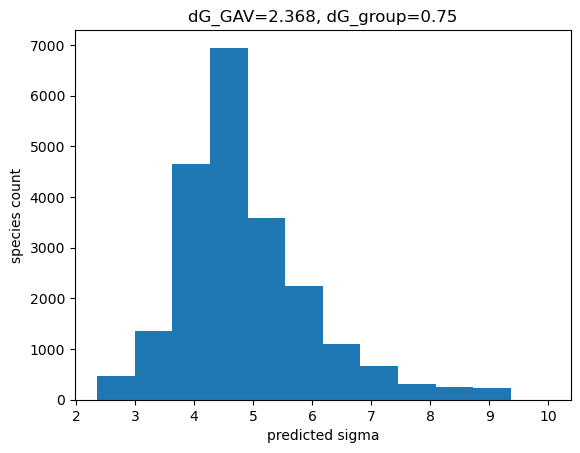

In [317]:
plt.hist(uncertainties, bins=np.linspace(2.36, 10, 13))
plt.xlabel('predicted sigma')
plt.ylabel('species count')
plt.title(f'dG_GAV={dG_GAV}, dG_group={dG_group}')

In [311]:
U_og = get_uncertainty_og(n_groups)

In [315]:
np.nanmedian(U_og)

2.0

In [299]:
np.nanmedian(uncertainties)

1.5811388300841898

In [303]:
np.nanmin(uncertainties_og)

1.2649110640673518

In [184]:
all_species[0].thermo = database.thermo.get_thermo_data_from_groups(all_species[i_sp])

In [198]:
database.thermo.extract_source_from_comments(all_species[7])

{'GAV': {'group': [(<Entry index=2317 label="O2s-OsH">, 2)],
  'radical': [(<Entry index=1876 label="HOOJ">, 2)]}}

In [190]:
gav_thermo.comment

''

In [201]:
database.thermo.groups

{'group': <rmgpy.data.thermo.ThermoGroups at 0x7fae5479bf10>,
 'ring': <rmgpy.data.thermo.ThermoGroups at 0x7fae520714c0>,
 'radical': <rmgpy.data.thermo.ThermoGroups at 0x7fae51303040>,
 'polycyclic': <rmgpy.data.thermo.ThermoGroups at 0x7fae50877040>,
 'other': <rmgpy.data.thermo.ThermoGroups at 0x7fae4e288040>,
 'longDistanceInteraction_cyclic': <rmgpy.data.thermo.ThermoGroups at 0x7fae512818b0>,
 'longDistanceInteraction_noncyclic': <rmgpy.data.thermo.ThermoGroups at 0x7fae51237fd0>,
 'adsorptionPt111': <rmgpy.data.thermo.ThermoGroups at 0x7fae4d459040>,
 'adsorptionLi': <rmgpy.data.thermo.ThermoGroups at 0x7fae4dff4040>}